In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, classification_report, roc_auc_score, make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('train_eda.csv')

In [3]:
%pip install xgboost
%pip install catboost

     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/70.9 MB 1.3 MB/s eta 0:00:54
     ---------------------------------------- 0.2/70.9 MB 1.6 MB/s eta 0:00:46
     ---------------------------------------- 0.3/70.9 MB 1.7 MB/s eta 0:00:41
     ---------------------------------------- 0.4/70.9 MB 1.9 MB/s eta 0:00:38
     ---------------------------------------- 0.6/70.9 MB 2.3 MB/s eta 0:00:31
      --------------------------------------- 0.9/70.9 MB 2.9 MB/s eta 0:00:24
      --------------------------------------- 1.5/70.9 MB 4.2 MB/s eta 0:00:17
      --------------------------------------- 1.7/70.9 MB 4.6 MB/s eta 0:00:15
      --------------------------------------- 1.7/70.9 MB 4.6 MB/s eta 0:00:15
     - -------------------------------------- 2.1/70.9 MB 4.4 MB/s eta 0:00:16
     - -------------------------------------- 2.6/70.9 MB 4.6 MB/s

In [4]:
df.shape

(542580, 199)

In [5]:
df.isnull().sum()

TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
dist1             0
P_emaildomain     0
R_emaildomain     0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
D1                0
D3                0
D4                0
D5                0
D8                0
D9                0
D10               0
D11               0
D13               0
D14               0
D15               0
M1                0
M2                0
M3                0
M4                0
M5                0
M6                0
M7                0
M8                0
M9                0


In [5]:
df.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D3                float64
D4                float64
D5                float64
D8                float64
D9                float64
D10               float64
D11               float64
D13         

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_28', 'id_29', 'id_31', 'id_32', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'OS_id_30',
       'version_id_30', 'DeviceCorp', 'hour_warning'],
      dtype='object')

In [7]:
df[categorical_columns].nunique()


ProductCD         5
card4             4
card6             3
P_emaildomain    19
R_emaildomain    10
M1                2
M2                2
M3                2
M4                3
M5                2
M6                2
M7                2
M8                2
M9                2
id_12             3
id_15             4
id_16             3
id_28             3
id_29             3
id_31            14
id_32             5
id_34             5
id_35             3
id_36             3
id_37             3
id_38             3
DeviceType        3
DeviceInfo       14
OS_id_30          8
version_id_30    43
DeviceCorp       33
hour_warning      4
dtype: int64

In [8]:
class_counts = df['isFraud'].value_counts()


total_samples = len(df)
percentage_fraud = (class_counts[1] / total_samples) * 100
percentage_non_fraud = (class_counts[0] / total_samples) * 100

print("Class Distribution:")
print("Fraud: {:.2f}%".format(percentage_fraud))
print("Non-Fraud: {:.2f}%".format(percentage_non_fraud))




Class Distribution:
Fraud: 3.45%
Non-Fraud: 96.55%


In [9]:
drop_cols = ['TransactionID', 'TransactionDT', 'isFraud']
X = df.drop(drop_cols, axis=1)
y = df["isFraud"]

numerical_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
scaler = MinMaxScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Label Encode categorical features
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


In [10]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [14]:
def feature_importance(model, x_train):
  importance = model.feature_importances_
  feature_importance = pd.DataFrame(importance, index=x_train.columns, columns=['Importances'])
  return feature_importance.sort_values(by=['Importances'], ascending=False)

# XGBoost

## Random Undersampling

In [19]:
from xgboost import XGBClassifier
xgb_rus = XGBClassifier(max_depth=10, n_estimators=100, random_state=42)
xgb_rus.fit(X_train_rus, y_train_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

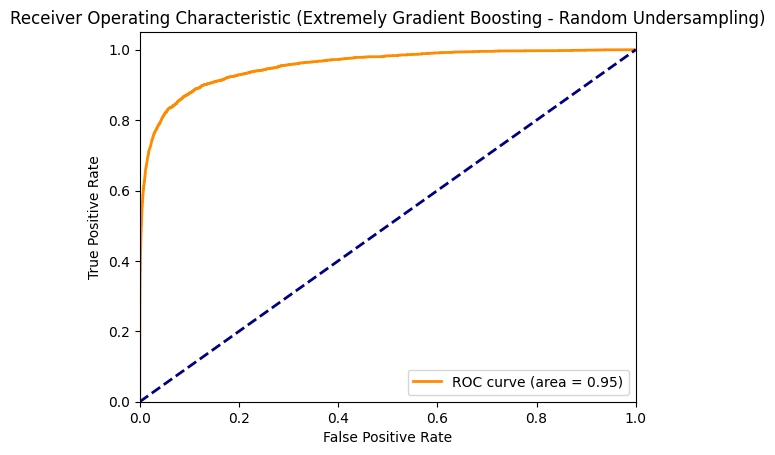

ExtremelyGradientBoosting (Random Undersampling) - Train AUC-ROC Score: 0.9985021197060491
ExtremelyGradientBoosting (Random Undersampling) - Test AUC-ROC Score: 0.954554725748229
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    104769
           1       0.39      0.80      0.53      3747

    accuracy                           0.95    108516
   macro avg       0.69      0.88      0.75    108516
weighted avg       0.97      0.95      0.96    108516



In [20]:
y_train_pred_xgb_rus = xgb_rus.predict(X_train_rus)


y_train_prob_xgb_rus = xgb_rus.predict_proba(X_train_rus)[:, 1]
roc_auc_train_xgb_rus = roc_auc_score(y_train_rus, y_train_prob_xgb_rus)


y_test_pred_xgb_rus = xgb_rus.predict(X_test)


y_test_prob_xgb_rus = xgb_rus.predict_proba(X_test)[:, 1]
roc_auc_test_xgb_rus = roc_auc_score(y_test, y_test_prob_xgb_rus)


fpr_xgb_rus, tpr_xgb_rus, _ = roc_curve(y_test, y_test_prob_xgb_rus)
plt.figure()
plt.plot(fpr_xgb_rus, tpr_xgb_rus, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_xgb_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Extremely Gradient Boosting - Random Undersampling)')
plt.legend(loc="lower right")
plt.show()


print("ExtremelyGradientBoosting (Random Undersampling) - Train AUC-ROC Score:", roc_auc_train_xgb_rus)
print("ExtremelyGradientBoosting (Random Undersampling) - Test AUC-ROC Score:", roc_auc_test_xgb_rus)

print("Classification Report:")
print(classification_report(y_test, y_test_pred_xgb_rus))

## SMOTE

In [21]:
xgb_smote = XGBClassifier(max_depth=10, n_estimators=100, random_state=42)
xgb_smote.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

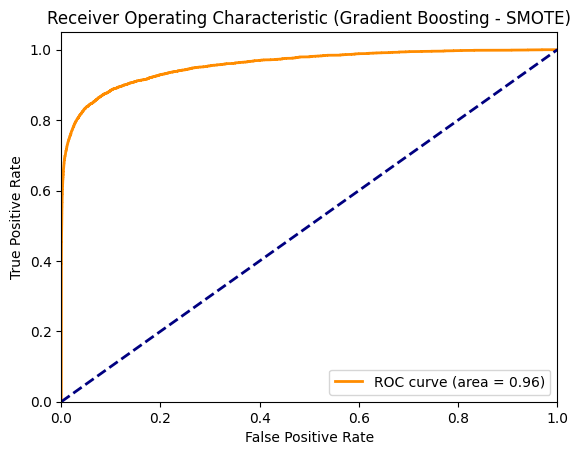

GradientBoosting (SMOTE) - Train AUC-ROC Score: 0.999293717925499
GradientBoosting (SMOTE) - Test AUC-ROC Score: 0.9568792966394992
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    104769
           1       0.92      0.58      0.71      3747

    accuracy                           0.98    108516
   macro avg       0.95      0.79      0.85    108516
weighted avg       0.98      0.98      0.98    108516



In [22]:
y_train_pred_xgb_smote = xgb_rus.predict(X_train_smote)


y_train_prob_xgb_smote = xgb_smote.predict_proba(X_train_smote)[:, 1]
roc_auc_train_xgb_smote = roc_auc_score(y_train_smote, y_train_prob_xgb_smote)


y_test_pred_xgb_smote = xgb_smote.predict(X_test)


y_test_prob_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]
roc_auc_test_xgb_smote = roc_auc_score(y_test, y_test_prob_xgb_smote)


fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_test, y_test_prob_xgb_smote)
plt.figure()
plt.plot(fpr_xgb_smote, tpr_xgb_smote, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_xgb_smote)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Extremely Gradient Boosting - SMOTE)')
plt.legend(loc="lower right")
plt.show()


print("ExtremelyGradientBoosting (SMOTE) - Train AUC-ROC Score:", roc_auc_train_xgb_smote)
print("ExtremelyGradientBoosting (SMOTE) - Test AUC-ROC Score:", roc_auc_test_xgb_smote)

print("Classification Report:")
print(classification_report(y_test, y_test_pred_xgb_smote))

## Hyperparameter Tunning

In [30]:
xgb_model_rus = XGBClassifier(max_depth=10, n_estimators=100, random_state=42)
param_dist = {
    'n_estimators': list(range(50,350,50)),
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
}


rs_rus = RandomizedSearchCV(estimator=xgb_model_rus, param_distributions=param_dist,
                            scoring='roc_auc', cv=5, n_iter=10, refit=True, random_state=42, n_jobs=-1)


rs_rus.fit(X_train_rus, y_train_rus)


print("Extremely Gradient Boosting (Random Undersampling) - Best Parameters:", rs_rus.best_params_)
print("Extremely Gradient Boosting (Random Undersampling) - Best Train AUC-ROC Score:", rs_rus.best_score_)


y_pred_rus = rs_rus.best_estimator_.predict(X_test)
y_prob_rus = rs_rus.best_estimator_.predict_proba(X_test)[:, 1]


test_roc_auc_rus = roc_auc_score(y_test, y_prob_rus)


print("Extremely Gradient Boosting (Random Undersampling) - Test AUC-ROC Score:", test_roc_auc_rus)

print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_rus))

Extremely Gradient Boosting (Random Undersampling) - Best Parameters: {'n_estimators': 300, 'learning_rate': 0.1}
Extremely Gradient Boosting (Random Undersampling) - Best Train AUC-ROC Score: 0.9540166218509454
Extremely Gradient Boosting (Random Undersampling) - Test AUC-ROC Score: 0.9585670438949575
Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    104769
           1       0.43      0.81      0.56      3747

    accuracy                           0.96    108516
   macro avg       0.71      0.89      0.77    108516
weighted avg       0.97      0.96      0.96    108516



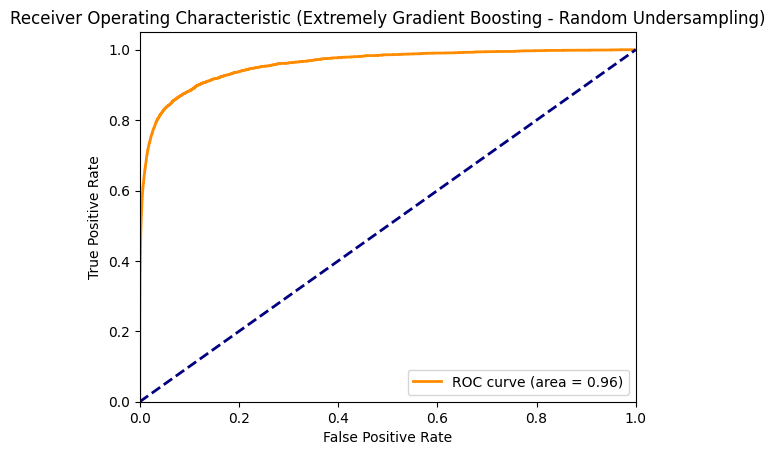

In [32]:
fpr_ada_rus, tpr_ada_rus, _ = roc_curve(y_test, y_prob_rus)
plt.figure()
plt.plot(fpr_ada_rus, tpr_ada_rus, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % test_roc_auc_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Extremely Gradient Boosting - Random Undersampling)')
plt.legend(loc="lower right")
plt.show()

# Catboost

## Random Undersampling

In [23]:
from catboost import CatBoostClassifier
cb_rus = CatBoostClassifier(max_depth=10, n_estimators=100, random_state=42)
cb_rus.fit(X_train_rus, y_train_rus)

Learning rate set to 0.432198
0:	learn: 0.5080643	total: 706ms	remaining: 1m 9s
1:	learn: 0.4375889	total: 1.41s	remaining: 1m 8s
2:	learn: 0.4021101	total: 2s	remaining: 1m 4s
3:	learn: 0.3823894	total: 2.58s	remaining: 1m 1s
4:	learn: 0.3730127	total: 3.28s	remaining: 1m 2s
5:	learn: 0.3584738	total: 3.91s	remaining: 1m 1s
6:	learn: 0.3554364	total: 4.49s	remaining: 59.6s
7:	learn: 0.3463666	total: 5.16s	remaining: 59.4s
8:	learn: 0.3403261	total: 5.9s	remaining: 59.7s
9:	learn: 0.3362804	total: 6.49s	remaining: 58.4s
10:	learn: 0.3307103	total: 7s	remaining: 56.6s
11:	learn: 0.3280169	total: 7.53s	remaining: 55.2s
12:	learn: 0.3204406	total: 7.99s	remaining: 53.4s
13:	learn: 0.3134136	total: 8.58s	remaining: 52.7s
14:	learn: 0.3103018	total: 9.25s	remaining: 52.4s
15:	learn: 0.3078890	total: 9.85s	remaining: 51.7s
16:	learn: 0.3005823	total: 10.4s	remaining: 50.7s
17:	learn: 0.2978045	total: 10.8s	remaining: 49.4s
18:	learn: 0.2955658	total: 11.3s	remaining: 48.1s
19:	learn: 0.28859

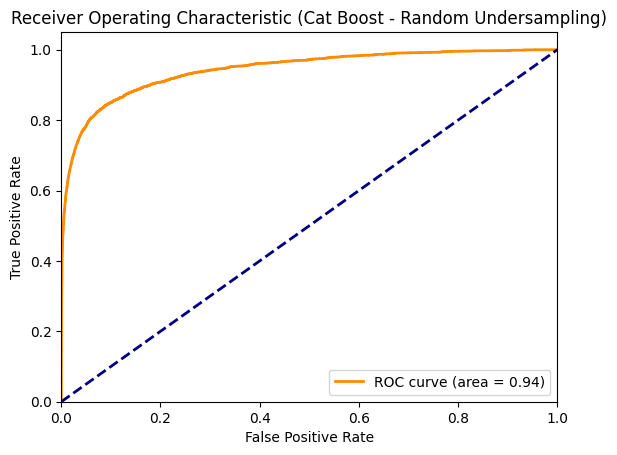

Cat Boost (Random Undersampling) - Train AUC-ROC Score: 0.9925174268260055
Cat Boost (Random Undersampling) - Test AUC-ROC Score: 0.9428375962517286
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    104769
           1       0.35      0.79      0.49      3747

    accuracy                           0.94    108516
   macro avg       0.67      0.87      0.73    108516
weighted avg       0.97      0.94      0.95    108516



In [24]:
y_train_pred_cb_rus = cb_rus.predict(X_train_rus)


y_train_prob_cb_rus = cb_rus.predict_proba(X_train_rus)[:, 1]
roc_auc_train_cb_rus = roc_auc_score(y_train_rus, y_train_prob_cb_rus)


y_test_pred_cb_rus = cb_rus.predict(X_test)


y_test_prob_cb_rus = cb_rus.predict_proba(X_test)[:, 1]
roc_auc_test_cb_rus = roc_auc_score(y_test, y_test_prob_cb_rus)


fpr_cb_rus, tpr_cb_rus, _ = roc_curve(y_test, y_test_prob_cb_rus)
plt.figure()
plt.plot(fpr_cb_rus, tpr_cb_rus, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_cb_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cat Boost - Random Undersampling)')
plt.legend(loc="lower right")
plt.show()


print("Cat Boost (Random Undersampling) - Train AUC-ROC Score:", roc_auc_train_cb_rus)
print("Cat Boost (Random Undersampling) - Test AUC-ROC Score:", roc_auc_test_cb_rus)

print("Classification Report:")
print(classification_report(y_test, y_test_pred_cb_rus))

## SMOTE

In [27]:
cb_smote = CatBoostClassifier(random_state=42)
cb_smote.fit(X_train_smote, y_train_smote)

Learning rate set to 0.161378
0:	learn: 0.5612377	total: 421ms	remaining: 7m
1:	learn: 0.4860356	total: 886ms	remaining: 7m 22s
2:	learn: 0.4175091	total: 1.43s	remaining: 7m 54s
3:	learn: 0.3682057	total: 1.87s	remaining: 7m 45s
4:	learn: 0.3374923	total: 2.33s	remaining: 7m 42s
5:	learn: 0.2975548	total: 2.86s	remaining: 7m 53s
6:	learn: 0.2819477	total: 3.29s	remaining: 7m 46s
7:	learn: 0.2679047	total: 3.7s	remaining: 7m 38s
8:	learn: 0.2536389	total: 4.13s	remaining: 7m 34s
9:	learn: 0.2363629	total: 4.56s	remaining: 7m 31s
10:	learn: 0.2214572	total: 4.99s	remaining: 7m 28s
11:	learn: 0.2163444	total: 5.3s	remaining: 7m 16s
12:	learn: 0.2062888	total: 5.74s	remaining: 7m 15s
13:	learn: 0.2011417	total: 6.06s	remaining: 7m 6s
14:	learn: 0.1979560	total: 6.36s	remaining: 6m 57s
15:	learn: 0.1946849	total: 6.73s	remaining: 6m 53s
16:	learn: 0.1890430	total: 7.18s	remaining: 6m 54s
17:	learn: 0.1855537	total: 7.53s	remaining: 6m 50s
18:	learn: 0.1826036	total: 7.83s	remaining: 6m 44s

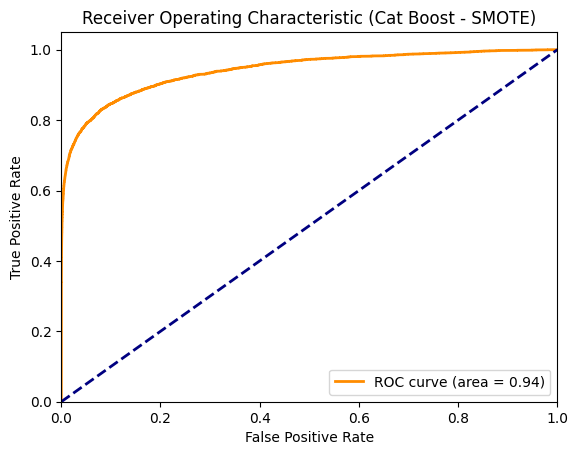

Cat Boost (SMOTE) - Train AUC-ROC Score: 0.9973918546868508
Cat Boost (SMOTE) - Test AUC-ROC Score: 0.9417703888888775
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    104769
           1       0.91      0.52      0.66      3747

    accuracy                           0.98    108516
   macro avg       0.95      0.76      0.83    108516
weighted avg       0.98      0.98      0.98    108516



In [28]:
y_train_pred_cb_smote = cb_rus.predict(X_train_smote)


y_train_prob_cb_smote = cb_smote.predict_proba(X_train_smote)[:, 1]
roc_auc_train_cb_smote = roc_auc_score(y_train_smote, y_train_prob_cb_smote)


y_test_pred_cb_smote = cb_smote.predict(X_test)


y_test_prob_cb_smote = cb_smote.predict_proba(X_test)[:, 1]
roc_auc_test_cb_smote = roc_auc_score(y_test, y_test_prob_cb_smote)


fpr_cb_smote, tpr_cb_smote, _ = roc_curve(y_test, y_test_prob_cb_smote)
plt.figure()
plt.plot(fpr_cb_smote, tpr_cb_smote, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_cb_smote)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Cat Boost - SMOTE)')
plt.legend(loc="lower right")
plt.show()


print("Cat Boost (SMOTE) - Train AUC-ROC Score:", roc_auc_train_cb_smote)
print("Cat Boost (SMOTE) - Test AUC-ROC Score:", roc_auc_test_cb_smote)

print("Classification Report:")
print(classification_report(y_test, y_test_pred_cb_smote))

## Hyperparameters Tuning

In [33]:
cb_model_rus = CatBoostClassifier(random_state=42)
param_dist = {
    'depth': [4, 7, 10],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'iterations': [500, 1000, 1500],
}


rs_rus = RandomizedSearchCV(estimator=cb_model_rus, param_distributions=param_dist,
                            scoring='roc_auc', cv=5, n_iter=10, refit=True, random_state=42, n_jobs=-1)


rs_rus.fit(X_train_rus, y_train_rus)


print("Cat Boost (Random Undersampling) - Best Parameters:", rs_rus.best_params_)
print("Cat Boost (Random Undersampling) - Best Train AUC-ROC Score:", rs_rus.best_score_)


y_pred_rus = rs_rus.best_estimator_.predict(X_test)
y_prob_rus = rs_rus.best_estimator_.predict_proba(X_test)[:, 1]


test_roc_auc_rus = roc_auc_score(y_test, y_prob_rus)


print("Cat Boost (Random Undersampling) - Test AUC-ROC Score:", test_roc_auc_rus)

print("Classification Report for the Best Model:")
print(classification_report(y_test, y_pred_rus))

0:	learn: 0.6363530	total: 309ms	remaining: 5m 8s
1:	learn: 0.5899741	total: 618ms	remaining: 5m 8s
2:	learn: 0.5530797	total: 931ms	remaining: 5m 9s
3:	learn: 0.5229231	total: 1.23s	remaining: 5m 5s
4:	learn: 0.4979639	total: 1.55s	remaining: 5m 7s
5:	learn: 0.4790404	total: 1.89s	remaining: 5m 12s
6:	learn: 0.4657514	total: 2.21s	remaining: 5m 13s
7:	learn: 0.4519212	total: 2.56s	remaining: 5m 17s
8:	learn: 0.4404100	total: 2.86s	remaining: 5m 15s
9:	learn: 0.4313256	total: 3.18s	remaining: 5m 15s
10:	learn: 0.4231381	total: 3.51s	remaining: 5m 15s
11:	learn: 0.4165395	total: 3.81s	remaining: 5m 13s
12:	learn: 0.4097712	total: 4.13s	remaining: 5m 13s
13:	learn: 0.4038704	total: 4.44s	remaining: 5m 12s
14:	learn: 0.3994691	total: 4.78s	remaining: 5m 14s
15:	learn: 0.3954500	total: 5.12s	remaining: 5m 14s
16:	learn: 0.3914470	total: 5.47s	remaining: 5m 16s
17:	learn: 0.3875519	total: 5.79s	remaining: 5m 15s
18:	learn: 0.3836455	total: 6.11s	remaining: 5m 15s
19:	learn: 0.3788874	total: